In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

# Notebook settings

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option("precision", 3)

# Data Cleaning

In [3]:
df = pd.read_csv("data/calibration-2021-03-13.csv")

In [49]:
# Removing irrelevant columns, id, state and question
df = df[["user", "lo", "hi", "ci", "solution"]]
# z: How many std deviations away is the solution from the hi/lo inferred normal
df["z"] = np.divide(
    2 * df["solution"] - (df["hi"] + df["lo"]), (df["hi"] - df["lo"]) / norm.ppf(0.95)
)
# The percentaliz based on the std_deviatins
df["z-percentile"] = df["z"].apply(norm.cdf)
# log(z): How many std deviations away is the solution from the hi/lo inferred lognormal
df["loglo"] = np.log(df["lo"])
df["loghi"] = np.log(df["hi"])
df["logsolution"] = np.log(df["solution"])
df["logz"] = np.divide(
    2 * df["solution"] - (df["loghi"] + df["loglo"]),
    (df["loghi"] - df["loglo"]) / norm.ppf(0.95),
)
# log(z): How many std deviations away is the solution from the hi/lo inferred lognormal
df["logz-percentile"] = df["logz"].apply(norm.cdf)

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
df.head()

,user,lo,hi,ci,solution,z,z-percentile,loglo,loghi,logsolution,logz,logz-percentile
0,user1,1800.0,2020,0.9,1987.0,1.151,0.875,7.496,7.611,7.594,56471.708,1.0
1,user1,1.0,100,0.9,53.0,0.083,0.533,0.000,4.605,3.970,36.216,1.0
2,user1,0.0,600,0.9,10.0,-1.590,0.056,-inf,6.397,2.303,NaN,NaN
3,user2,0.0,20,0.9,70.0,9.869,1.000,-inf,2.996,4.248,NaN,NaN
4,user3,0.0,16,0.9,70.0,12.748,1.000,-inf,2.773,4.248,NaN,NaN


In [51]:
df.logz.isna().value_counts()

False    348
True      18
Name: logz, dtype: int64

# z-score density

In [52]:
norm.cdf(-1)

0.15865525393145707

In [53]:
norm.ppf(0.05)

-1.6448536269514729

In [63]:
df[df["z-percentile"].between(0.05, 0.15)]

,user,lo,hi,ci,solution,z,z-percentile,loglo,loghi,logsolution,logz,logz-percentile
2,user1,0.0,600,0.9,10.00,-1.590,0.056,-inf,6.397,2.303,NaN,NaN
10,user3,1.0,100000000,0.9,1000000.00,-1.612,0.053,0.000,18.421,13.816,178586.069,1.000
11,user2,1.0,1000,0.9,8.00,-1.622,0.052,0.000,6.908,2.079,2.165,0.985
13,user3,0.0,500,0.9,10.00,-1.579,0.057,-inf,6.215,2.303,NaN,NaN
18,user3,0.0,10000,0.9,1.28,-1.644,0.050,-inf,9.210,0.247,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
356,user2,0.1,100,0.9,6.00,-1.451,0.073,-2.303,4.605,1.792,2.309,0.990
357,user3,5.0,110,0.9,6.00,-1.614,0.053,1.609,4.700,1.792,3.028,0.999
358,user2,1.0,1000,0.9,50.00,-1.483,0.069,0.000,6.908,3.912,22.167,1.000
359,user3,50.0,900,0.9,50.00,-1.645,0.050,3.912,6.802,3.912,50.811,1.000


array([[<AxesSubplot:title={'center':'z-percentile'}>]], dtype=object)

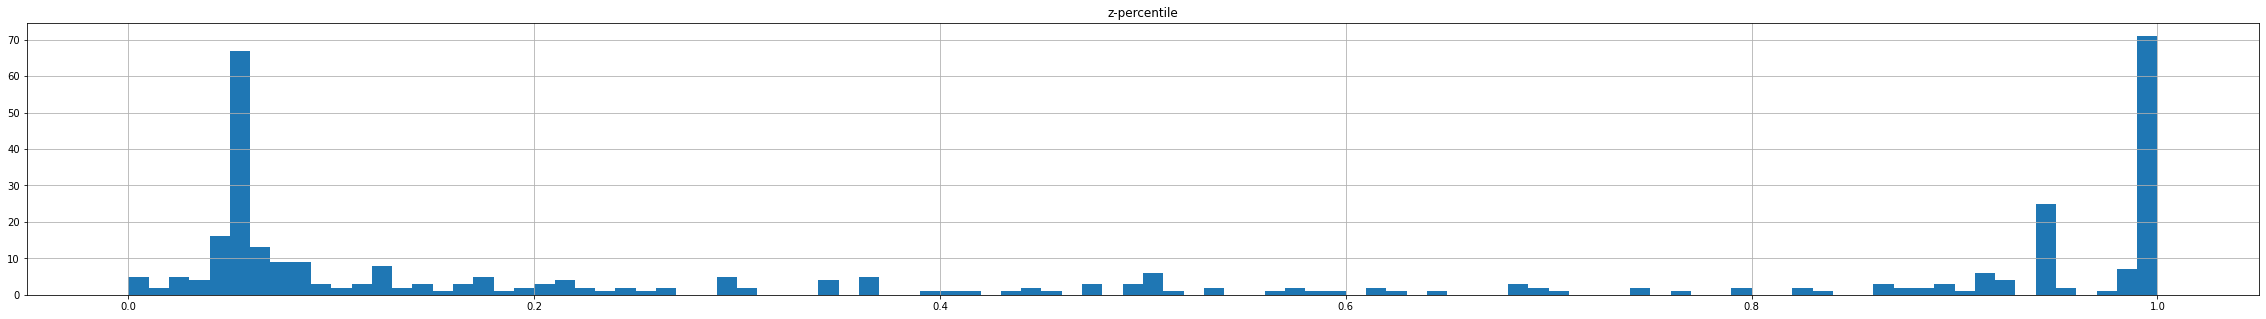

In [64]:
df.hist("z-percentile", bins=100, figsize=(40, 5))

array([[<AxesSubplot:title={'center':'logz-percentile'}>]], dtype=object)

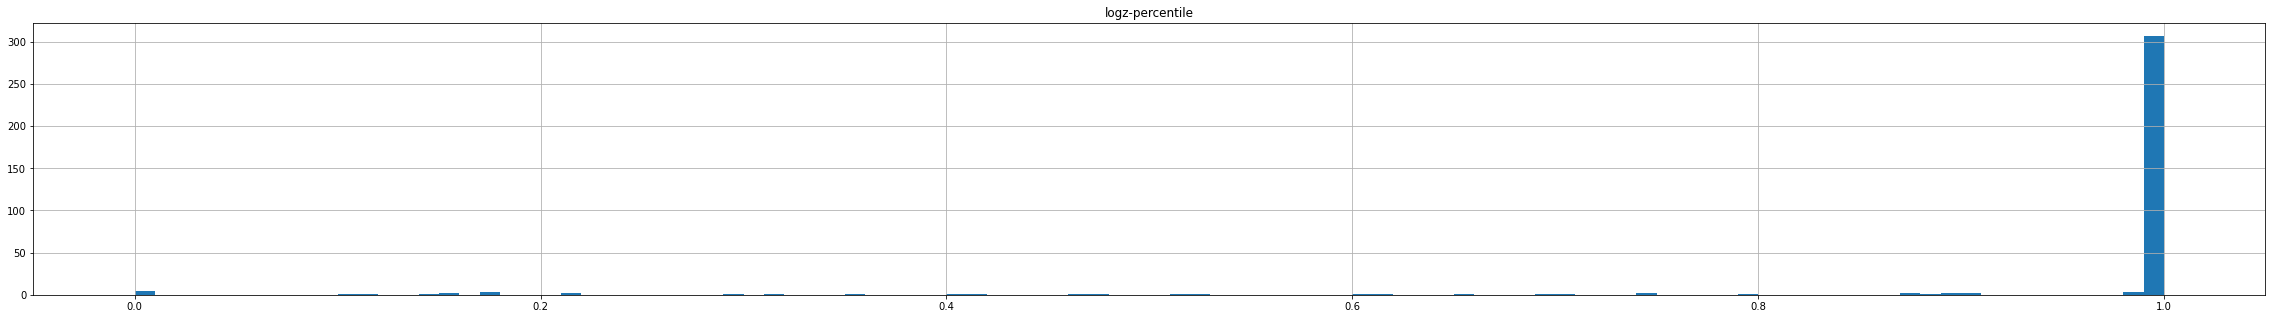

In [58]:
df.hist("logz-percentile", bins=100, figsize=(40, 5))

# Auxiliary functions 

In [57]:
def get_user_table(user):
    return df[df["user"] == user][[col for col in df.columns if col != "user"]]

# Add metrics

In [11]:
n_buckets = 20
buckets = np.divide(range(1, n_buckets, 1), n_buckets)
print(buckets)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [12]:
for ci_size in tqdm(buckets):
    alpha = np.divide(1 - ci_size, 2)
    df[f"ci-{ci_size}"] = df["z"].map(
        lambda x: x > norm.ppf(alpha) and x < norm.ppf(1 - alpha)
    )

for ci_size in tqdm(buckets):
    alpha = np.divide(1 - ci_size, 2)
    df[f"log_ci-{ci_size}"] = df["logz"].map(
        lambda x: x > norm.ppf(alpha) and x < norm.ppf(1 - alpha)
    )

100%|██████████| 19/19 [00:02<00:00,  8.58it/s]


In [13]:
df.head()

,user,lo,hi,ci,solution,z,z-percentile,loglo,loghi,logsolution,...,log_ci-0.5,log_ci-0.55,log_ci-0.6,log_ci-0.65,log_ci-0.7,log_ci-0.75,log_ci-0.8,log_ci-0.85,log_ci-0.9,log_ci-0.95
0,user1,1800.0,2020,0.9,1987.0,0.213,0.584,7.496,7.611,7.594,...,False,False,False,False,False,False,False,False,False,False
1,user1,1.0,100,0.9,53.0,0.015,0.506,0.000,4.605,3.970,...,False,False,False,False,False,False,False,False,False,False
2,user1,0.0,600,0.9,10.0,-0.294,0.384,-inf,6.397,2.303,...,False,False,False,False,False,False,False,False,False,False
3,user2,0.0,20,0.9,70.0,1.824,0.966,-inf,2.996,4.248,...,False,False,False,False,False,False,False,False,False,False
4,user3,0.0,16,0.9,70.0,2.356,0.991,-inf,2.773,4.248,...,False,False,False,False,False,False,False,False,False,False


# Calculating the buckets

In [14]:
def get_percentage(user, column):
    results = df[df["user"] == user][column].value_counts()
    return np.divide(results[True], results[True] + results[False])

In [15]:
users = df.user.unique()
df_metrics = pd.DataFrame(index=users)
for ci in buckets:
    df_metrics[ci] = df_metrics.index.map(lambda user: get_percentage(user, f"ci-{ci}"))

df_metrics.loc["perfect"] = buckets

KeyError: True

In [ ]:
df_metrics.T.style.background_gradient(cmap="viridis", axis=1)

In [ ]:
df_metrics.loc["user3"].plot(legend=True, figsize=(20, 5))
df_metrics.loc["perfect"].plot(legend=True, figsize=(20, 5))

In [ ]:
for user in df_metrics.index:
    df_metrics.loc[user].plot(legend=True, figsize=(20, 5))

In [ ]:
df_metrics["avg_abs_error"] = np.mean(np.abs(df_metrics[buckets] - buckets), axis=1)
df_metrics["bias"] = np.mean(df_metrics[buckets] - buckets, axis=1)
df_metrics.T.style.background_gradient(cmap="viridis", axis=1)